In [28]:
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt

In [29]:
def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map


def arcmin2rad(arcmin):
    return arcmin * np.pi / 180 / 60

def compute_power_spectrum(map1, ellmax, map2 = None, fsky = None):
    if map2 is not None:
        cl = hp.anafast(map1, map2, lmax= ellmax)
    else:
        cl = hp.anafast(map1, lmax= ellmax)
    if fsky is not None:
        cl /= fsky
    return cl

def normalize_cl(cl, ells = None):
    if ells is None:
        ells = np.arange(len(cl))
    return cl *(ells * (ells + 1))/ (2*np.pi )

In [30]:
nside = 512
ellmax = 2*nside
ells = np.arange(ellmax + 1)

In [31]:
mask_path = '/shared/data/Datasets/I_512_1450_variance_noise/Simulation_Mask/mask.fits'
mask = hp.read_map(mask_path)
fsky = np.sum(mask**2)/len(mask)

In [32]:
beam_fwhm = 20.6 # arcmin
beam_fwhm = arcmin2rad(beam_fwhm)
beam = hp.gauss_beam(beam_fwhm, lmax=ellmax)

## Weighted foreground component maps with monopole and dipole

In [33]:
foreground_res_dir = '/home/yunan/pyilc/output/foreground/'

In [34]:
fg_res_maps_path = {'dust': foreground_res_dir + 'dust/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'synchrotron' : foreground_res_dir + 's4/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'freefree' : foreground_res_dir + 'f1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'ame' : foreground_res_dir + 'a1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'CO' : foreground_res_dir + 'co1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'CIB' : foreground_res_dir + 'cib1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'tsz' : foreground_res_dir + 'tsz1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'ksz' : foreground_res_dir + 'ksz1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'radio galaxy' : foreground_res_dir + 'rg1/CN_needletILCmap_component_CMB_foreground_res.fits',
                    'combined' : foreground_res_dir + 'combined/CN_needletILCmap_component_CMB_foreground_res.fits'
                    }

In [35]:
fg_res_maps = {fg: hp.read_map(fg_res_maps_path[fg]) for fg in fg_res_maps_path}

In [36]:
fg_res_maps_masked = {fg: apply_mask(fg_res_maps[fg], mask) for fg in fg_res_maps}

In [37]:
cl_fg_res = {fg: compute_power_spectrum(fg_res_maps_masked[fg], ellmax, fsky=fsky) for fg in fg_res_maps_masked}

In [38]:
cl_fg_res_beam = {fg: cl_fg_res[fg]/beam**2 for fg in cl_fg_res}

In [39]:
dl_fg_res_beam = {fg: normalize_cl(cl_fg_res_beam[fg]) for fg in cl_fg_res_beam}

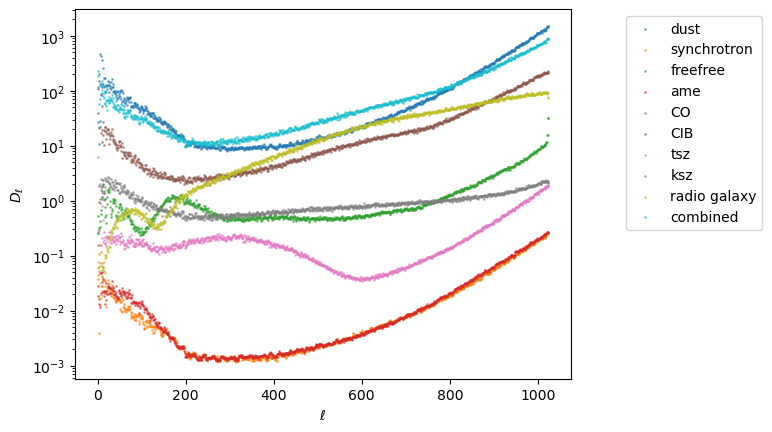

In [40]:
for fg in dl_fg_res_beam:
    plt.scatter(ells, dl_fg_res_beam[fg], label=fg, s=1, alpha=0.5)
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

# <span style="color: #FF5733;">Removing dipole and monopole for the output weighted foreground maps</span>

In [41]:
fg_res_maps = {fg: hp.read_map(fg_res_maps_path[fg]) for fg in fg_res_maps_path}   
fg_res_maps = {fg: hp.remove_monopole(hp.remove_dipole(fg_res_maps[fg])) for fg in fg_res_maps}
fg_res_maps = {fg: hp.remove_dipole(fg_res_maps[fg]) for fg in fg_res_maps} 

fg_res_maps_masked = {fg: apply_mask(fg_res_maps[fg], mask) for fg in fg_res_maps}

cl_fg_res = {fg: compute_power_spectrum(fg_res_maps_masked[fg], ellmax, fsky=fsky) for fg in fg_res_maps_masked}

cl_fg_res_beam = {fg: cl_fg_res[fg]/beam**2 for fg in cl_fg_res}

dl_fg_res_beam_md = {fg: normalize_cl(cl_fg_res_beam[fg]) for fg in cl_fg_res_beam}

/home/yunan/miniconda3/envs/ml_cmb/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in scalar divide
  ang[0, :] = np.arccos(vz / r)


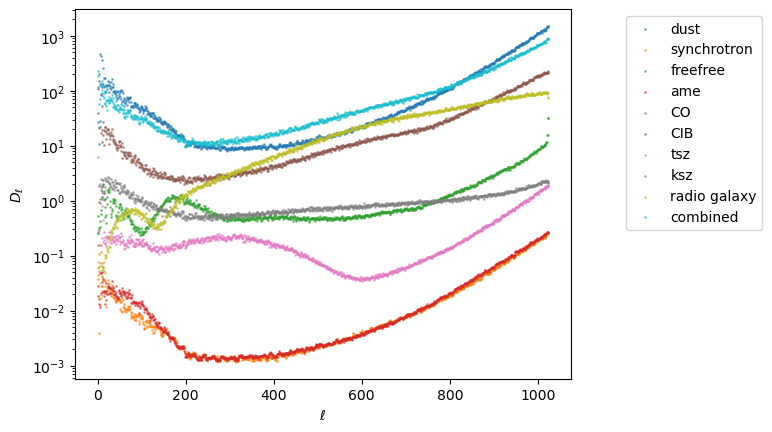

In [42]:
for fg in dl_fg_res_beam:
    plt.scatter(ells, dl_fg_res_beam[fg], label=fg, s=1, alpha=0.5)
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

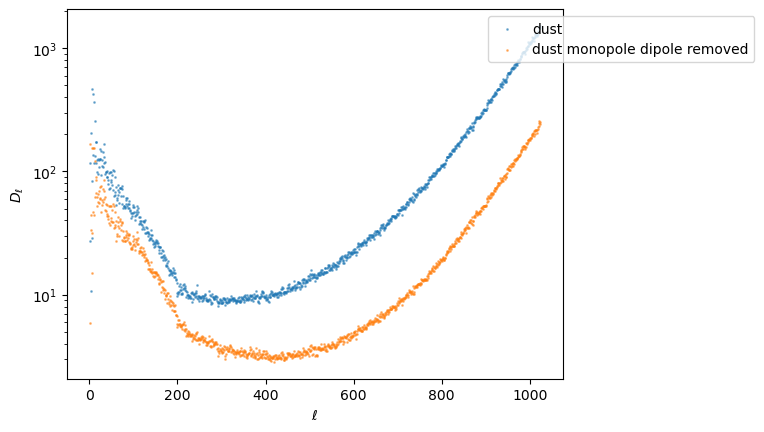

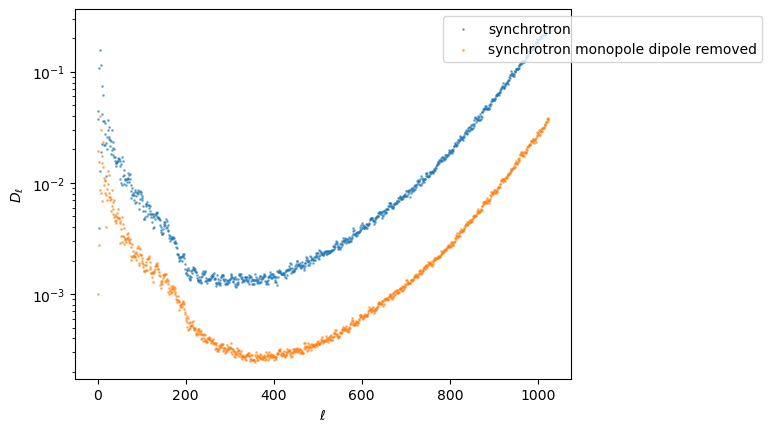

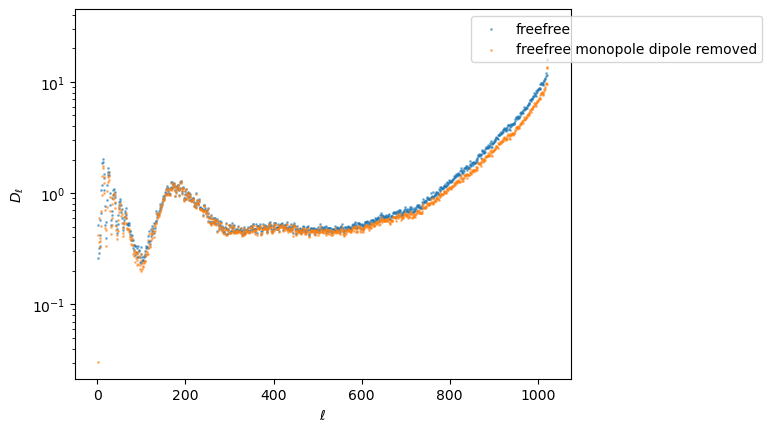

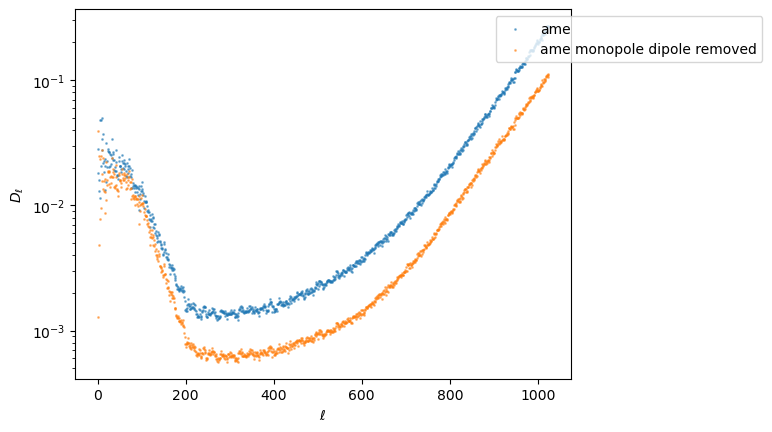

/tmp/ipykernel_834873/1504222432.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


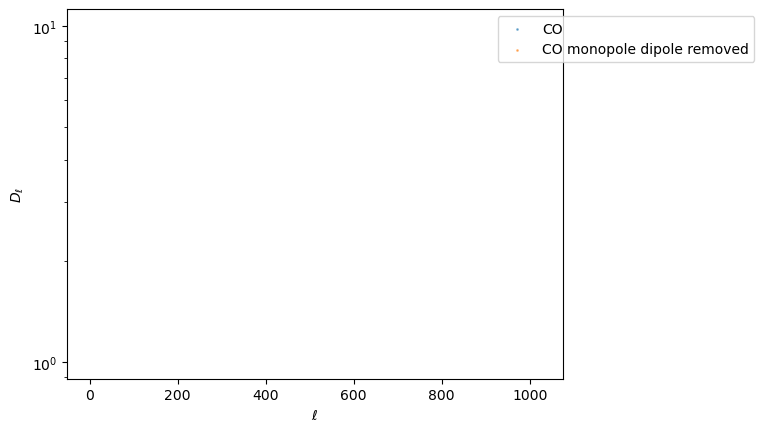

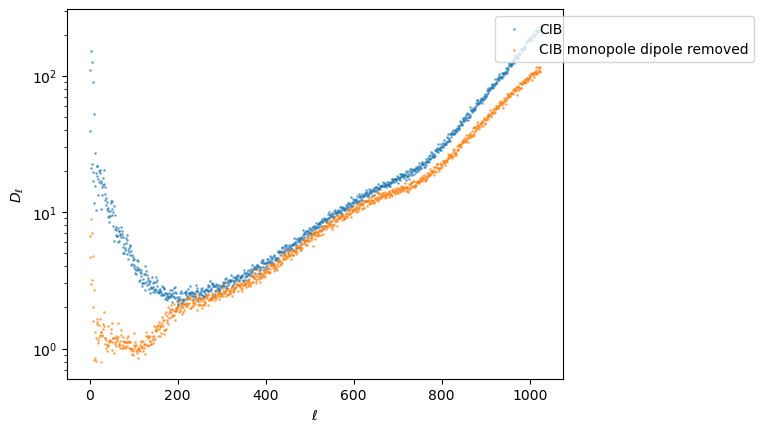

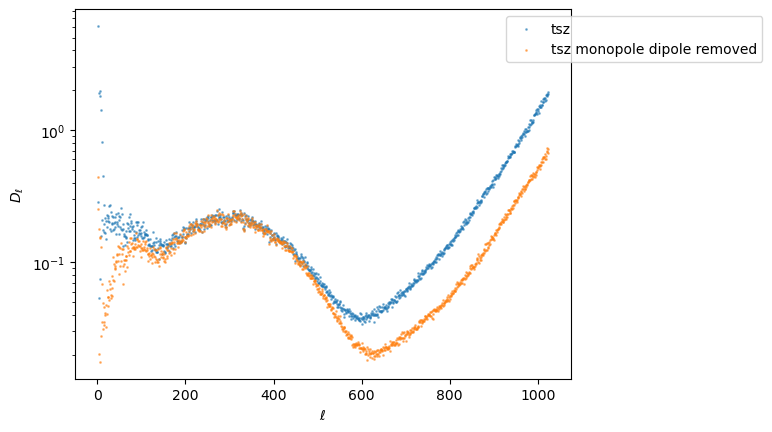

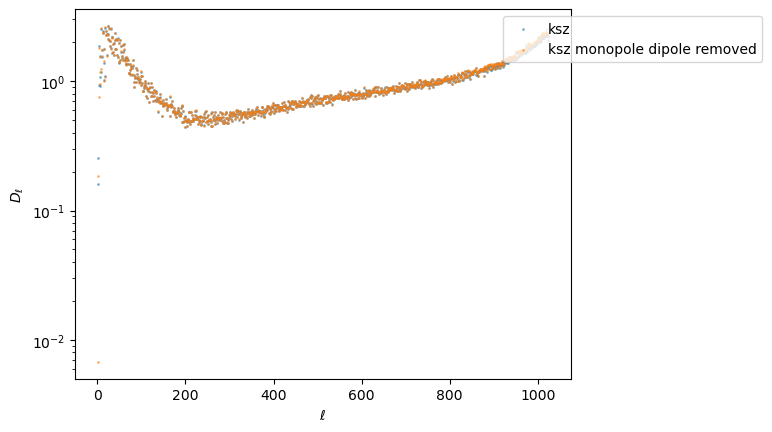

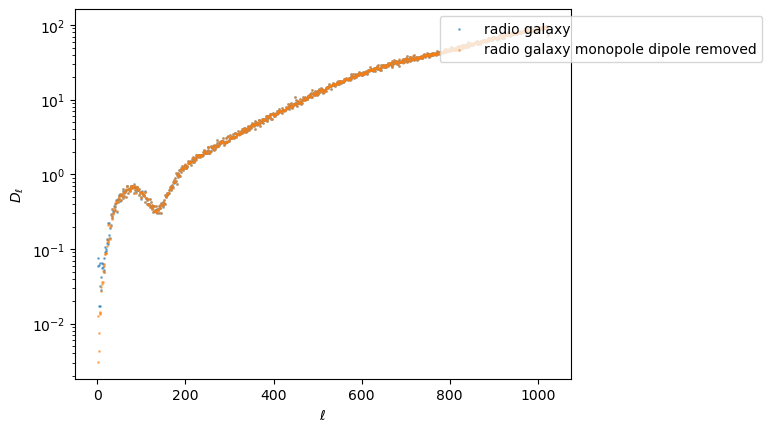

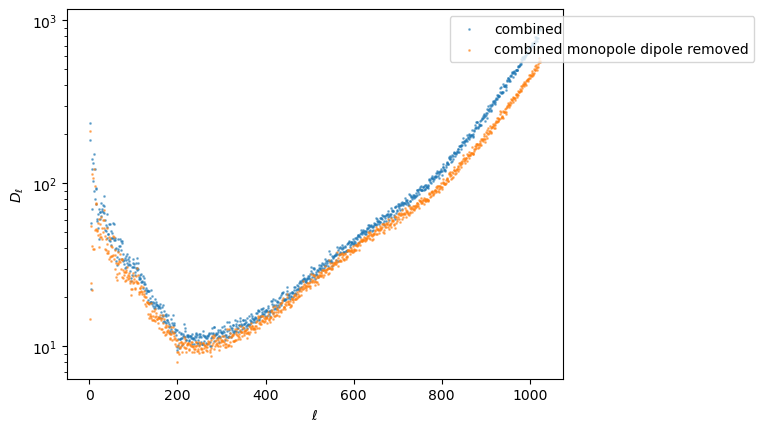

In [43]:
for fg in dl_fg_res_beam:
    fig = plt.figure()
    plt.scatter(ells, dl_fg_res_beam[fg], label=fg, s=1, alpha=0.5)
    plt.scatter(ells, dl_fg_res_beam_md[fg], label=fg + ' monopole dipole removed', s=1, alpha=0.5)
    plt.yscale('log')
    plt.xlabel('$\ell$')
    plt.ylabel('$D_{\ell}$')
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.show()

## For dust only demonstrations

In [68]:
dust_test = {}
for sim_num in range(20):
    fn = f'/home/yunan/pyilc/output/foreground/d9/sim{sim_num:03d}/CN_needletILCmap_component_CMB_foreground_res.fits'
    map = hp.read_map(fn)
    map_masked = apply_mask(map, mask)
    cl = compute_power_spectrum(map_masked, ellmax, fsky=fsky)
    cl_beam = cl/beam**2
    dl = normalize_cl(cl_beam)
    dust_test[sim_num] = dl

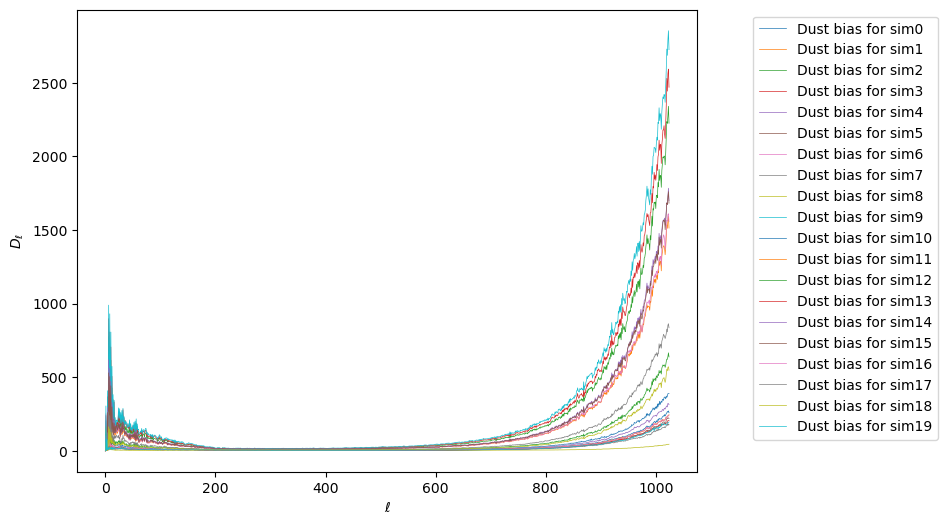

In [69]:
plt.figure(figsize=(8, 6))
for sim_num in dust_test:
    plt.plot(ells, dust_test[sim_num], label=f'Dust bias for sim{sim_num}', linewidth=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.4, 1))
plt.show()

In [70]:
dust_test_avg = np.mean([dust_test[sim_num] for sim_num in dust_test], axis=0)

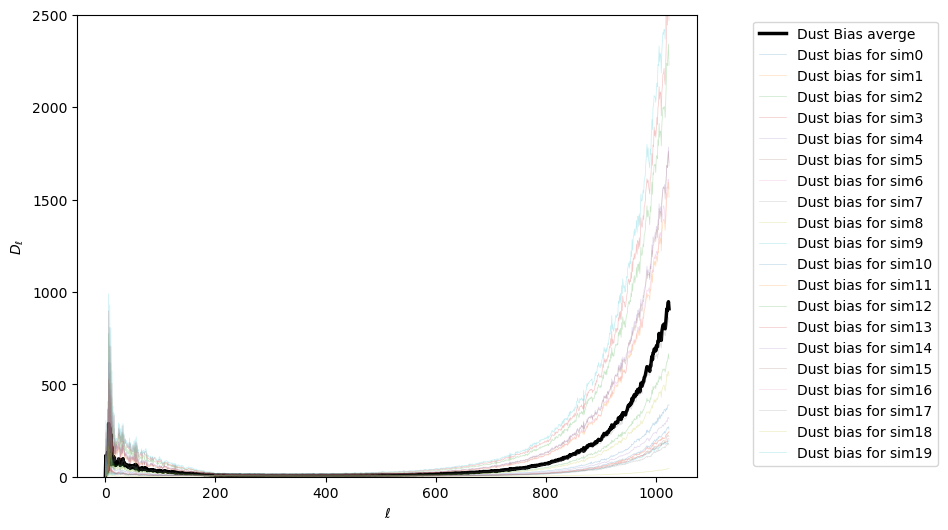

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(ells, dust_test_avg, label='Dust Bias averge', c = 'black',linewidth= 2.5, alpha = 1)
for sim_num in dust_test:
    plt.plot(ells, dust_test[sim_num], label=f'Dust bias for sim{sim_num}', linewidth=0.5, alpha = 0.25)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.4, 1))
plt.ylim(0, 2.5e3)
plt.show()

### Remove dipole and monopole

In [72]:
dust_test = {}
for sim_num in range(20):
    fn = f'/home/yunan/pyilc/output/foreground/d9/sim{sim_num:03d}/CN_needletILCmap_component_CMB_foreground_res.fits'
    map = hp.read_map(fn)
########## remove monopole and dipole
    map = hp.remove_monopole(map)
    map = hp.remove_dipole(map)
########## remove monopole and dipole end
    map_masked = apply_mask(map, mask)
    cl = compute_power_spectrum(map_masked, ellmax, fsky=fsky)
    cl_beam = cl/beam**2
    dl = normalize_cl(cl_beam)
    dust_test[sim_num] = dl

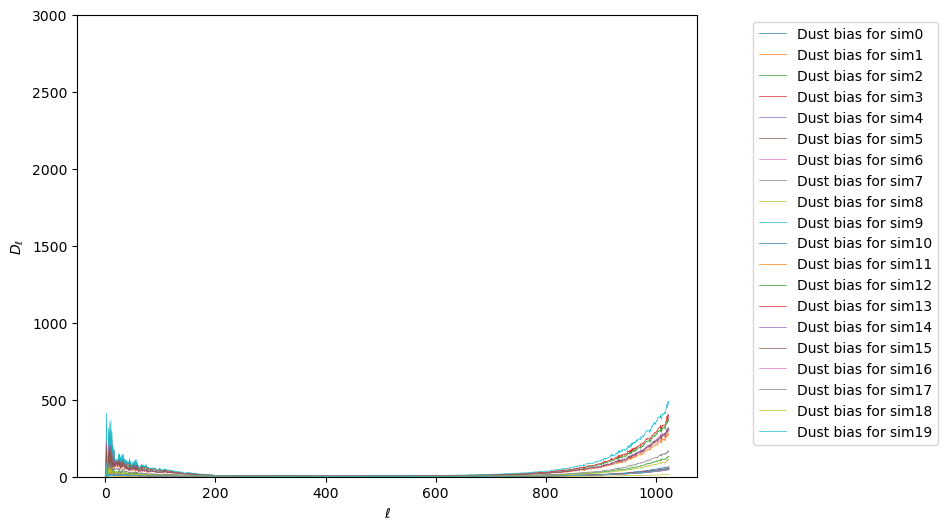

In [76]:
plt.figure(figsize=(8, 6))
for sim_num in dust_test:
    plt.plot(ells, dust_test[sim_num], label=f'Dust bias for sim{sim_num}', linewidth=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.4, 1))
plt.ylim(0, 3e3)
plt.show()

In [77]:
dust_test_avg = np.mean([dust_test[seed] for seed in dust_test], axis=0)

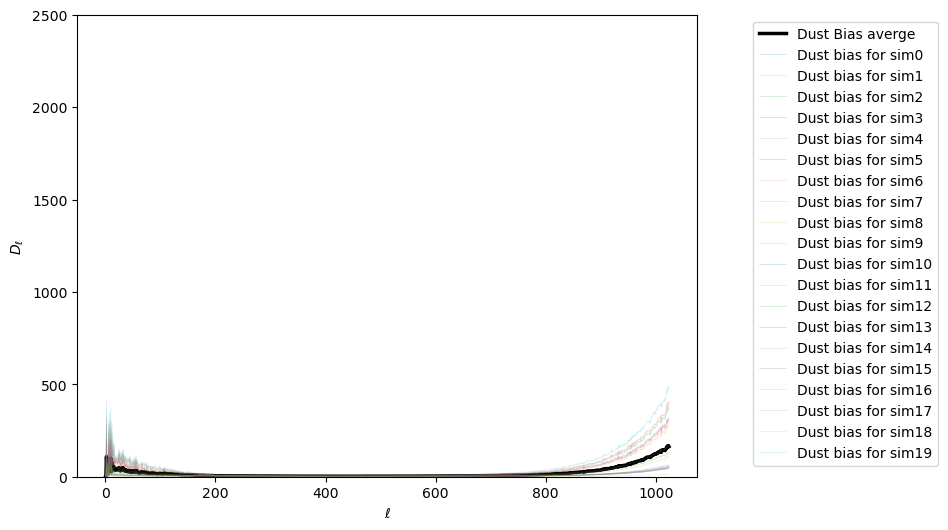

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(ells, dust_test_avg, label='Dust Bias averge', c = 'black',linewidth= 2.5, alpha = 1)
for sim_num in dust_test:
    plt.plot(ells, dust_test[sim_num], label=f'Dust bias for sim{sim_num}', linewidth=0.5, alpha = 0.25)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.4, 1))
plt.ylim(0, 2.5e3)
plt.show()